# ML Cup Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss, mee
from utils import DataLoader
from utils import plot_curves
from utils import StandardScaler
from utils.model_selection_helpers import instability_coeff, tran_val_diff, count_parameters
from utils.grid_search import grid_search_mlcup
from IPython.display import clear_output

np.random.seed(8)

In [2]:
# Load Data
PATH = 'data/ML CUP/ML-CUP25-TR.csv'
df = pd.read_csv(PATH, comment='#', header=None)

dataset = np.array(df)
X = dataset[:, 1:-4]
y = dataset[:, -4:]

print(f"X.shape: {X.shape}, y.shape: {y.shape} ")
train_test_dataset = DataLoader(X, y)
X_train, y_train, X_test, y_test = train_test_dataset.train_val_split(portion = 0.8, shuffle = True)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
train_val_dataset = DataLoader(X_train, y_train)

X.shape: (500, 12), y.shape: (500, 4) 
X_train.shape: (400, 12), y_train.shape: (400, 4), X_test.shape: (100, 12), y_test.shape: (100, 4)


In [3]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 12
OUTPUT_NEURONS = 4

HIDDEN_LAYER_SIZES = [8, 16, 32]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('identity', 'mse')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS = [0.1, 0.05]
LAMBDA_CONFIGURATIONS = [0, 1e-1, 1e-3] # we have to make them small because they are independent of eta
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
BATCH_SIZES = [64, -1] 

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 100

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

print(f"Total configurations: {LEN_CONFIGURATIONS}")

Total configurations: 648


In [4]:
def print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS, CONFIG_DICTIONARY_TRAIN_LOSS, min_mee = 100.0, sec_metric = 'val stab'):
    # print the top 25 configurations, sorting criterias: 1 avg mee
    #sometimes gradient explodes and mee is nan
    assert sec_metric in ['val stab', 'overfit', 'parameters'], "choose a parameter between 'val stab', 'overfit', 'parameters'"
        
    valid_id = []
    for i in CONFIG_DICTIONARY:
        if not np.isnan(CONFIG_DICTIONARY[i]):
            valid_id.append(i)
        
    if sec_metric == 'val stab':
        TOP_25_CONFIGS_INDEXES = sorted(valid_id, key=lambda i: (max(min_mee, CONFIG_DICTIONARY[i] / K_FOLDS), CONFIG_DICTIONARY_INSTABILITY_VAL[i]))[:25]
    if sec_metric == 'overfit':
        TOP_25_CONFIGS_INDEXES = sorted(valid_id, key=lambda i: (max(min_mee, CONFIG_DICTIONARY[i] / K_FOLDS), CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i]))[:25]
    if sec_metric == 'parameters':
        TOP_25_CONFIGS_INDEXES = sorted(valid_id, key=lambda i: (max(min_mee, CONFIG_DICTIONARY[i] / K_FOLDS), count_parameters(CONFIGURATIONS[i][0])))[:25]
    
    print("Top 25 configurations:")
    for i in TOP_25_CONFIGS_INDEXES:
        MEE = CONFIG_DICTIONARY[i]/ K_FOLDS
        print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean MEE (best of each epoch): {MEE},
            training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
            training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
            training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
            Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS},
            Mean Test Loss (last epoch nn according to val): {np.mean(CONFIG_DICTIONARY_TEST_LOSS[i])},
            Std Test Loss (last epoch nn according to val): {np.std(CONFIG_DICTIONARY_TEST_LOSS[i])},
            Mean Train Loss (last wepoch nn according to val): {np.mean(CONFIG_DICTIONARY_TRAIN_LOSS[i])},
            Std Train Loss (last epoch nn according to val): {np.std(CONFIG_DICTIONARY_TRAIN_LOSS[i])}
            ''')

## Grid Search

In [5]:
k_fold = train_val_dataset.k_fold(k = K_FOLDS)
grid_s_outputs =  grid_search_mlcup(LEN_CONFIGURATIONS, CONFIGURATIONS, k_fold, EPOCHS, EARLY_STOPPING_PATIENCE)
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS, CONFIG_DICTIONARY_TRAIN_LOSS = grid_s_outputs
clear_output(wait=False)

In [9]:
print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS, CONFIG_DICTIONARY_TRAIN_LOSS, min_mee= 21.5, sec_metric = 'val stab') ## if many NN have MEE , 23 -> we choose the most stableML_Cup_internal_test.ipynb

Top 25 configurations:
Config index: ([12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1), Avg Epochs: 827, Mean MEE (best of each epoch): 21.42464664114587,
            training instability coeff validation: 0.673773199356931, 
            training instability coeff train: 0.5399767396542754, 
            training loss-val loss diff: 70.78310831831926, 
            Mean Epochs: 827,
            Mean Test Loss (last epoch nn according to val): 21.41966790695764,
            Std Test Loss (last epoch nn according to val): 0.7682862643016937,
            Mean Train Loss (last wepoch nn according to val): 19.258783842464872,
            Std Train Loss (last epoch nn according to val): 0.2986657311213303
            
Config index: ([12, 16, 16, 4], ['tanh', 'tanh', 'identity'], 'mse', 0.05, 0.001, 0.9, -1), Avg Epochs: 884, Mean MEE (best of each epoch): 21.465094344195855,
            training instability coeff validation: 1.0463411245509746, 
            training instability c

## Some Experiments with validation set
We test some configurations and plot the results

In [11]:
# divide the train set in train and val to see how some configurations behave
X_train_exp, y_train_exp, X_test_exp, y_test_exp = train_val_dataset.train_val_split(portion = 0.8, shuffle = True)

### Lowest mean test loss at last epoch
Test Loss (last epoch) is too high and unstable

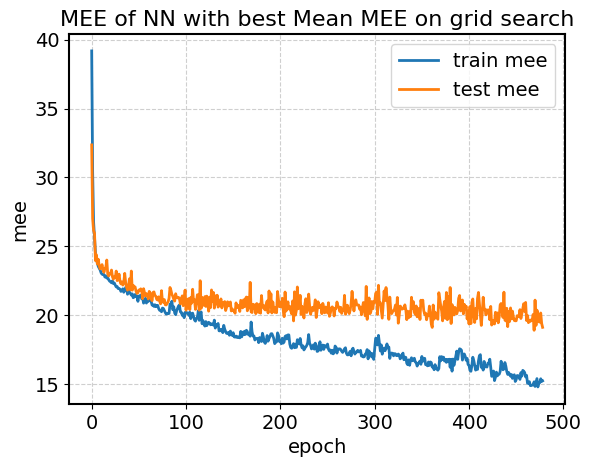

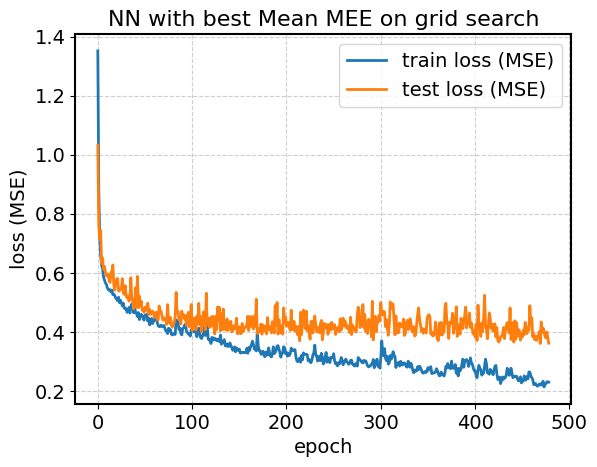

Train MEE: 14.692120796611537
Test MEE: 19.11623337739012


In [ ]:
'''Config index: ([12, 32, 32, 4], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.05, 0.001, 0.9, 64), Avg Epochs: 479, Mean MEE (best of each epoch): 19.806613807812433,
            training instability coeff validation: 18.86797998785415, 
            training instability coeff train: 7.955502350675206, 
            training loss-val loss diff: 66.0931309768494, 
            Mean Epochs: 479,
            Mean Test Loss (last epoch nn according to val): 20.622951242722888,
            Std Test Loss (last epoch nn according to val): 1.3390524715087282,
            Mean Train Loss (last wepoch nn according to val): 15.695105853244893,
            Std Train Loss (last epoch nn according to val): 1.0725833487389098
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 32, 32, 4], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.05, 0.001, 0.9, 64
EPOCHS = 479

#scaling
X_scaler = StandardScaler(X_train_exp)
X_train_scaled = X_scaler.transform(X_train_exp)
X_val_scaled = X_scaler.transform(X_test_exp)
y_scaler = StandardScaler(y_train_exp)
y_train_scaled = y_scaler.transform(y_train_exp)
y_val_scaled = y_scaler.transform(y_test_exp)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_mee= True, plot_title = 'MEE of NN with best Mean MEE on grid search', y_rescaler = y_scaler)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Loss NN with best Mean MEE on grid search', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y_train_exp, out)
print(f"Train MEE: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y_test_exp, out)
print(f"Test MEE: {np.mean(test_loss)}")

### Good Mean test loss at last epoch, good std test loss, low train instability coefficient
unluckly sometimes the error spikes, making the configuration not suitable for the final choice

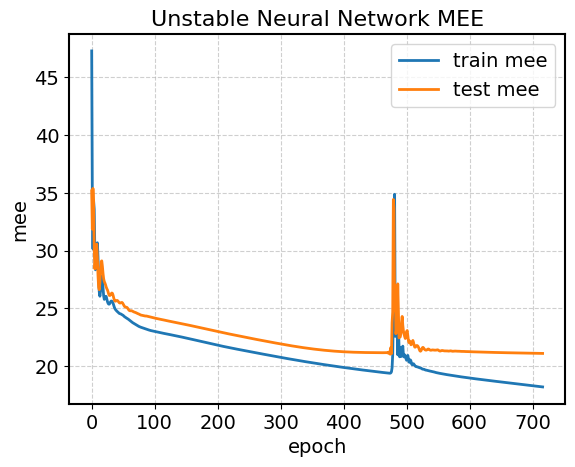

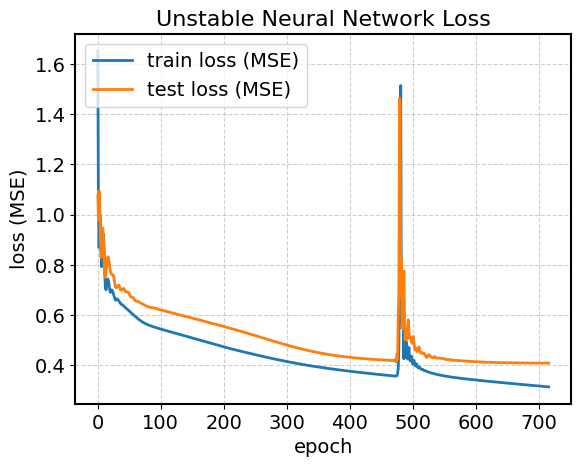

Train MEE: 18.195427884619562
Test MEE: 21.102824854232715


In [15]:
'''Config index: ([12, 32, 32, 4], ['tanh', 'tanh', 'identity'], 'mse', 0.05, 0, 0.9, -1), Avg Epochs: 717, Mean MEE (best of each epoch): 21.04609489087083,
            training instability coeff validation: 2.2650823081050215, 
            training instability coeff train: 1.9364435724808948, 
            training loss-val loss diff: 76.91487938495433, 
            Mean Epochs: 717,
            Mean Test Loss (last epoch nn according to val): 21.19851130557733,
            Std Test Loss (last epoch nn according to val): 0.48895085831205704,
            Mean Train Loss (last wepoch nn according to val): 17.5854051739146,
            Std Train Loss (last epoch nn according to val): 1.3248901449466473'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 32, 32, 4], ['tanh', 'tanh', 'identity'], 'mse', 0.05, 0, 0.9, -1
EPOCHS = 717

#scaling
X_scaler = StandardScaler(X_train_exp)
X_train_scaled = X_scaler.transform(X_train_exp)
X_val_scaled = X_scaler.transform(X_test_exp)
y_scaler = StandardScaler(y_train_exp)
y_train_scaled = y_scaler.transform(y_train_exp)
y_val_scaled = y_scaler.transform(y_test_exp)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_mee= True, plot_title = 'Unstable Neural Network MEE', y_rescaler = y_scaler)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Unstable Neural Network Loss', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y_train_exp, out)
print(f"Train MEE: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y_test_exp, out)
print(f"Test MEE: {np.mean(test_loss)}")

### Stable, small, neural network


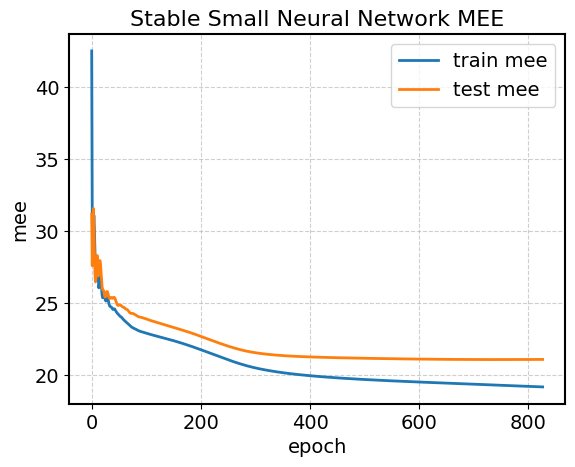

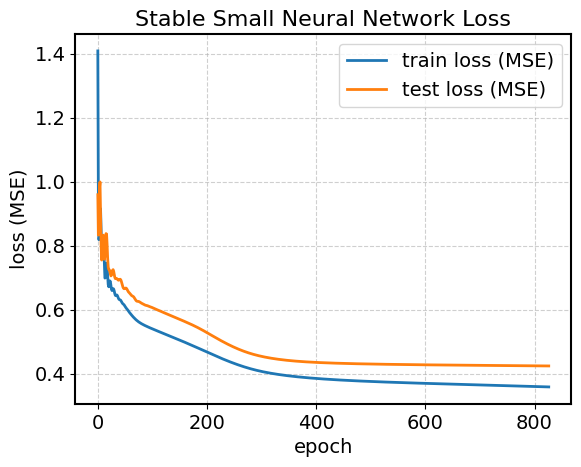

Train MEE: 19.16438778625668
Test MEE: 21.07619475368477


In [16]:
"""Config index: ([12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1), Avg Epochs: 827, Mean MEE (best of each epoch): 21.42464664114587,
            training instability coeff validation: 0.673773199356931, 
            training instability coeff train: 0.5399767396542754, 
            training loss-val loss diff: 70.78310831831926, 
            Mean Epochs: 827,
            Mean Test Loss (last epoch nn according to val): 21.41966790695764,
            Std Test Loss (last epoch nn according to val): 0.7682862643016937,
            Mean Train Loss (last wepoch nn according to val): 19.258783842464872,
            Std Train Loss (last epoch nn according to val): 0.2986657311213303"""

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1
EPOCHS = 827

#scaling
X_scaler = StandardScaler(X_train_exp)
X_train_scaled = X_scaler.transform(X_train_exp)
X_val_scaled = X_scaler.transform(X_test_exp)
y_scaler = StandardScaler(y_train_exp)
y_train_scaled = y_scaler.transform(y_train_exp)
y_val_scaled = y_scaler.transform(y_test_exp)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_mee= True, plot_title = 'Stable Small Neural Network MEE', y_rescaler = y_scaler)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Stable Small Neural Network Loss', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y_train_exp, out)
print(f"Train MEE: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y_test_exp, out)
print(f"Test MEE: {np.mean(test_loss)}")

## Internal Test

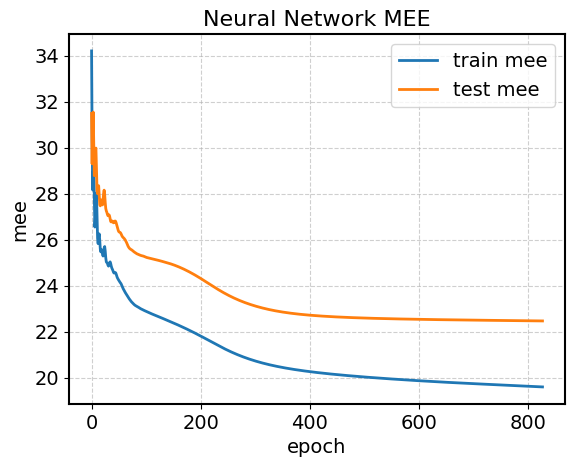

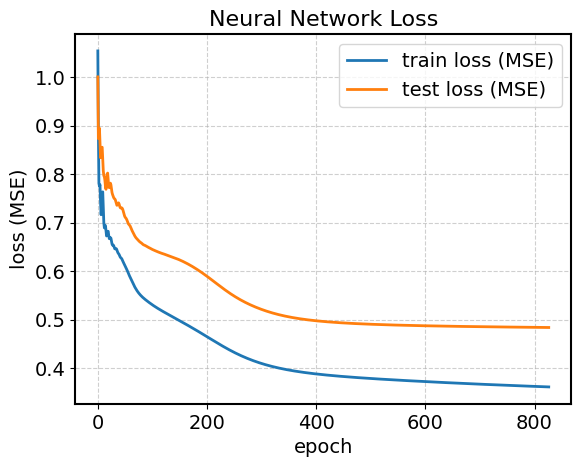

Train MEE: 19.594605247732094
Test MEE: 22.464405462404617


In [ ]:
### chosen configuration -> chosen for: mean mee, stabil valid, low std test loss
"""Config index: ([12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1), Avg Epochs: 827, Mean MEE (best of each epoch): 21.42464664114587,
            training instability coeff validation: 0.673773199356931, 
            training instability coeff train: 0.5399767396542754, 
            training loss-val loss diff: 70.78310831831926, 
            Mean Epochs: 827,
            Mean Test Loss (last epoch nn according to val): 21.41966790695764,
            Std Test Loss (last epoch nn according to val): 0.7682862643016937,
            Mean Train Loss (last wepoch nn according to val): 19.258783842464872,
            Std Train Loss (last epoch nn according to val): 0.2986657311213303"""

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1
EPOCHS = 827

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_val_scaled = y_scaler.transform(y_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_mee= True, plot_title = 'Neural Network MEE', y_rescaler = y_scaler)

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network Loss', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y_train, out)
print(f"Train MEE: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y_test, out)
print(f"Test MEE: {np.mean(test_loss)}")

## Final Submission

In [12]:
# Load Data
PATH_TR = 'data/ML CUP/ML-CUP25-TR.csv'
PATH_TS = 'data/ML CUP/ML-CUP25-TS.csv'

df = pd.read_csv(PATH_TR, comment='#', header=None)

dataset = np.array(df)
X_tr = dataset[:, 1:-4]
y = dataset[:, -4:]

df = pd.read_csv(PATH_TS, comment='#', header=None)

dataset = np.array(df)
X_ts = dataset[:, 1:]

print(f"X_tr.shape: {X_tr.shape}, y.shape: {y.shape},  X_ts.shape: {X_ts.shape}")
dataset = DataLoader(X_tr, y)

X_tr.shape: (500, 12), y.shape: (500, 4),  X_ts.shape: (1000, 12)


In [ ]:
### chosen configuration -> chosen for: mean mee, stabil valid, low std test loss
"""Config index: ([12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1), Avg Epochs: 827, Mean MEE (best of each epoch): 21.42464664114587,
            training instability coeff validation: 0.673773199356931, 
            training instability coeff train: 0.5399767396542754, 
            training loss-val loss diff: 70.78310831831926, 
            Mean Epochs: 827,
            Mean Test Loss (last epoch nn according to val): 21.41966790695764,
            Std Test Loss (last epoch nn according to val): 0.7682862643016937,
            Mean Train Loss (last wepoch nn according to val): 19.258783842464872,
            Std Train Loss (last epoch nn according to val): 0.2986657311213303"""

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [12, 16, 4], ['tanh', 'identity'], 'mse', 0.1, 0.001, 0.9, -1
EPOCHS = 827

#scaling
X_scaler = StandardScaler(X_tr)
X_train_scaled = X_scaler.transform(X_tr)
X_val_scaled = X_scaler.transform(X_ts)
y_scaler = StandardScaler(y)
y_train_scaled = y_scaler.transform(y)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=True)

# Train MAE
out = nn.forward(X_val_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
print(out.shape)

epoch 0 ---------------------
train loss: 2.1944619192833046
epoch 1 ---------------------
train loss: 1.1021033499247566
epoch 2 ---------------------
train loss: 0.9092803553431557
epoch 3 ---------------------
train loss: 1.0571475932421126
epoch 4 ---------------------
train loss: 1.0112100573126703
epoch 5 ---------------------
train loss: 0.89847418995838
epoch 6 ---------------------
train loss: 0.8588996387208029
epoch 7 ---------------------
train loss: 0.9130299719998577
epoch 8 ---------------------
train loss: 0.9422013728144116
epoch 9 ---------------------
train loss: 0.8787208527378516
epoch 10 ---------------------
train loss: 0.8056397995328297
epoch 11 ---------------------
train loss: 0.8049944713551362
epoch 12 ---------------------
train loss: 0.8194154028226304
epoch 13 ---------------------
train loss: 0.7935954278341343
epoch 14 ---------------------
train loss: 0.763492435374533
epoch 15 ---------------------
train loss: 0.7484452645845973
epoch 16 ------------

In [14]:
# nome team "Fraleli"
# membri "Alessandro Tesi, Elia Bocini, Francesco Fiaschi"
# data = "21/01/2026"

df_submission = pd.DataFrame(out)
df_submission.index = df_submission.index + 1  #adjust index to follow cup 25 csv
df_submission.to_csv('FRALELI_ML-CUP25-TS.csv') ### RICORDATI DI AGGIUNGERE I COMMENTI